# GameTheory 8c - Jeux Combinatoires : Approfondissement Python

**Navigation** : [<< 8-CombinatorialGames (track principal)](GameTheory-8-CombinatorialGames.ipynb) | [Index](README.md)

**Autres side tracks** : [8b-Lean-CombinatorialGames](GameTheory-8b-Lean-CombinatorialGames.ipynb)

**Kernel** : Python 3

---

## Introduction

Ce notebook est un **side track** du notebook 8 (CombinatorialGames). Il suppose que vous avez deja etudie :
- Les positions P et N
- Le jeu de Nim et le theoreme de Bouton
- La fonction mex et les valeurs de Grundy
- Le theoreme de Sprague-Grundy

Ici, nous explorons des **jeux plus complexes** et des **techniques avancees** :

1. **Periodicite** des valeurs de Grundy
2. **Jeu de Wythoff** - une generalisation elegante de Nim
3. **Jeux multi-composantes** - application de Sprague-Grundy
4. **Visualisations interactives**
5. **Jeu de Chomp** - un jeu partizan

### Duree estimee : 45 minutes

### Prerequis
- Notebook 8 : Jeux Combinatoires (concepts de base)

In [1]:
# Configuration et imports
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache
from typing import List, Set, Tuple, Optional

print("Notebook 8c - Jeux Combinatoires : Approfondissement")
print("="*55)

Notebook 8c - Jeux Combinatoires : Approfondissement


---

## Fonctions de base (rappel du notebook 8)

Ces fonctions sont definies dans le notebook 8. Nous les rappelons ici pour l'autonomie du notebook.

In [2]:
def mex(s: set) -> int:
    """Minimum excludant."""
    n = 0
    while n in s:
        n += 1
    return n

def grundy_subtraction(n: int, moves: set, memo: dict = None) -> int:
    """Valeur de Grundy pour le jeu de soustraction S(moves)."""
    if memo is None:
        memo = {}
    if n in memo:
        return memo[n]
    if n == 0:
        return 0
    
    reachable = set()
    for m in moves:
        if m <= n:
            reachable.add(grundy_subtraction(n - m, moves, memo))
    
    result = mex(reachable)
    memo[n] = result
    return result

def nim_sum(*values) -> int:
    """XOR de plusieurs valeurs."""
    result = 0
    for v in values:
        result ^= v
    return result

print("Fonctions de base chargees.")

Fonctions de base chargees.


---

## 1. Periodicite des valeurs de Grundy

Pour les jeux de soustraction, les valeurs de Grundy deviennent souvent **periodiques** apres un certain point.

### Theoreme (Guy, 1996)

Pour tout jeu de soustraction $S(M)$ ou $M$ est fini, les valeurs de Grundy sont **ultimement periodiques** : il existe $p$ (periode) et $n_0$ (pre-periode) tels que :

$$\forall n \geq n_0 : G(n + p) = G(n)$$

In [3]:
def find_periodicity(moves: set, max_n: int = 500, min_period: int = 5) -> Tuple[int, int, List[int]]:
    """
    Detecte la periode et la pre-periode des valeurs de Grundy.
    Retourne (pre-periode, periode, sequence).
    """
    memo = {}
    sequence = [grundy_subtraction(n, moves, memo) for n in range(max_n)]
    
    # Chercher une periode
    for pre_period in range(max_n // 3):
        for period in range(1, (max_n - pre_period) // 3):
            is_periodic = True
            for i in range(min(100, max_n - pre_period - period)):
                if sequence[pre_period + i] != sequence[pre_period + period + i]:
                    is_periodic = False
                    break
            if is_periodic and period >= min_period:
                return pre_period, period, sequence
    
    return -1, -1, sequence  # Periode non trouvee

# Analyser plusieurs jeux de soustraction
games = [
    {1, 2},      # Nim modifie
    {1, 3},      # 
    {1, 3, 4},   # Exemple classique
    {1, 2, 5},   # 
    {2, 5, 7},   # Sans 1
]

print("Periodicite des jeux de soustraction")
print("="*50)
print(f"{'Moves':<15} | {'Pre-periode':>12} | {'Periode':>8}")
print("-"*50)

for moves in games:
    pre, period, seq = find_periodicity(moves)
    if period > 0:
        print(f"{str(moves):<15} | {pre:>12} | {period:>8}")
    else:
        print(f"{str(moves):<15} | {'?':>12} | {'?':>8}")

Periodicite des jeux de soustraction
Moves           |  Pre-periode |  Periode
--------------------------------------------------
{1, 2}          |            0 |        6
{1, 3}          |            0 |        6
{1, 3, 4}       |            0 |        7
{1, 2, 5}       |            0 |        6
{2, 5, 7}       |            0 |       22


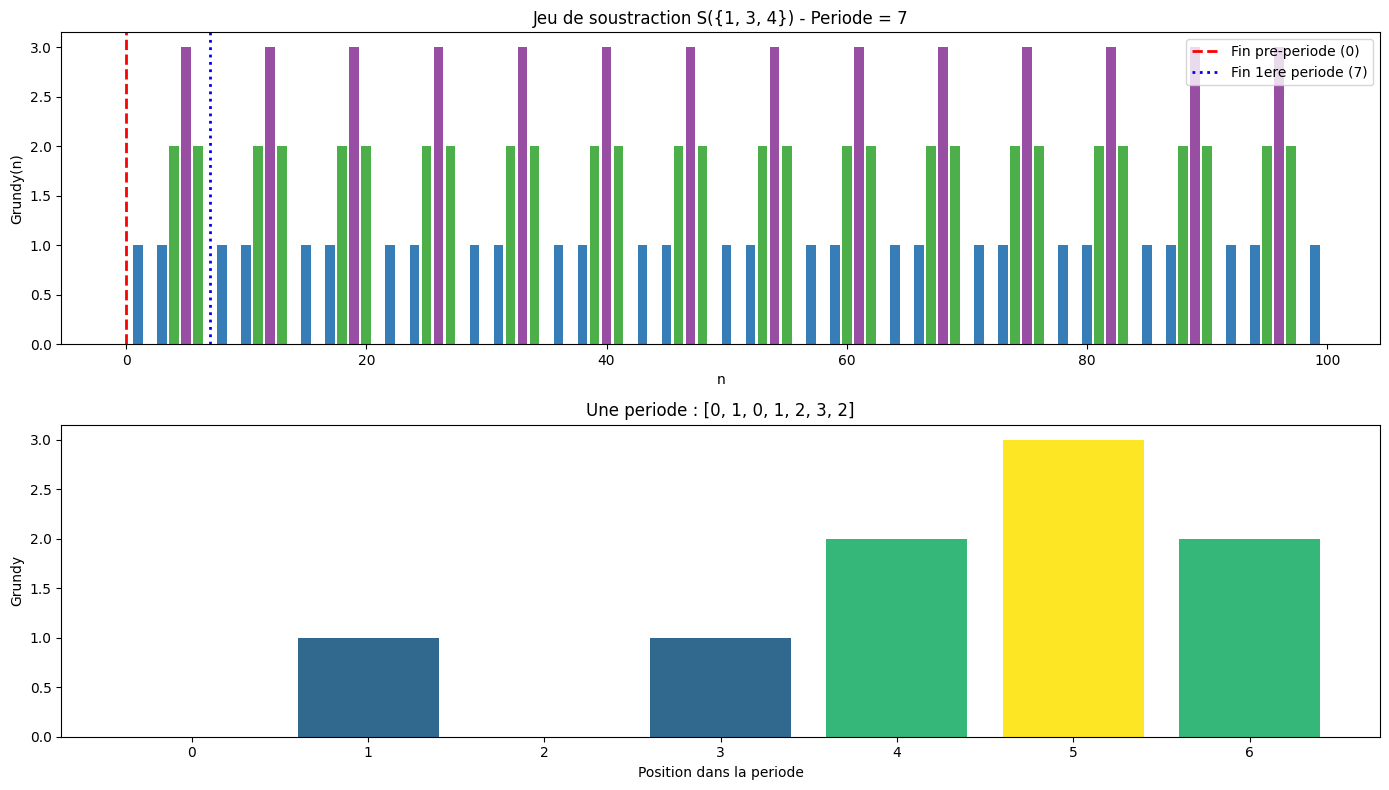


Pre-periode: 0, Periode: 7
Motif periodique: [0, 1, 0, 1, 2, 3, 2]


In [4]:
# Visualisation de la periodicite
moves = {1, 3, 4}
pre, period, seq = find_periodicity(moves, max_n=100)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Graphique 1: Sequence complete avec coloration
n_values = list(range(len(seq)))
colors = ['lightgray' if i < pre else plt.cm.Set1((seq[i] % 8) / 8) for i in n_values]

ax1.bar(n_values, seq, color=colors, edgecolor='none')
ax1.axvline(x=pre, color='red', linestyle='--', linewidth=2, label=f'Fin pre-periode ({pre})')
ax1.axvline(x=pre + period, color='blue', linestyle=':', linewidth=2, label=f'Fin 1ere periode ({pre + period})')
ax1.set_xlabel('n')
ax1.set_ylabel('Grundy(n)')
ax1.set_title(f'Jeu de soustraction S({moves}) - Periode = {period}')
ax1.legend()

# Graphique 2: Une periode isolee
one_period = seq[pre:pre + period]
ax2.bar(range(period), one_period, color=[plt.cm.viridis(g / max(one_period) if max(one_period) > 0 else 0) for g in one_period])
ax2.set_xlabel('Position dans la periode')
ax2.set_ylabel('Grundy')
ax2.set_title(f'Une periode : {one_period}')

plt.tight_layout()
plt.show()

print(f"\nPre-periode: {pre}, Periode: {period}")
print(f"Motif periodique: {one_period}")

---

## 2. Jeu de Wythoff

Le **jeu de Wythoff** (1907) est une generalisation elegante du Nim a 2 tas :

- Deux tas de jetons $(a, b)$
- A chaque tour, on peut :
  1. Retirer des jetons d'un seul tas (comme Nim)
  2. Retirer le **meme nombre** des deux tas (diagonale)

### P-positions

Les P-positions sont $(\lfloor n\phi \rfloor, \lfloor n\phi^2 \rfloor)$ ou $\phi = \frac{1+\sqrt{5}}{2}$ (nombre d'or).

Premieres P-positions : (0,0), (1,2), (3,5), (4,7), (6,10), (8,13), ...

In [5]:
# Nombre d'or
PHI = (1 + np.sqrt(5)) / 2

def wythoff_p_positions(n_max: int) -> List[Tuple[int, int]]:
    """Genere les P-positions du jeu de Wythoff."""
    p_positions = []
    for n in range(n_max):
        a = int(n * PHI)
        b = int(n * PHI * PHI)
        if b <= n_max:
            p_positions.append((a, b))
    return p_positions

def is_wythoff_p_position(a: int, b: int) -> bool:
    """Verifie si (a,b) est une P-position (Beatty sequence)."""
    if a > b:
        a, b = b, a
    if a == 0 and b == 0:
        return True
    # Utiliser la caracterisation de Beatty
    n = b - a
    expected_a = int(n * PHI)
    expected_b = int(n * PHI * PHI)
    return a == expected_a and b == expected_b

# Afficher les premieres P-positions
p_pos = wythoff_p_positions(20)
print("P-positions du jeu de Wythoff:")
print("="*40)
for i, (a, b) in enumerate(p_pos[:15]):
    diff = b - a
    print(f"  n={i}: ({a}, {b})  [difference = {diff}]")

print(f"\nNombre d'or phi = {PHI:.6f}")
print(f"phi^2 = {PHI**2:.6f} = phi + 1")

P-positions du jeu de Wythoff:
  n=0: (0, 0)  [difference = 0]
  n=1: (1, 2)  [difference = 1]
  n=2: (3, 5)  [difference = 2]
  n=3: (4, 7)  [difference = 3]
  n=4: (6, 10)  [difference = 4]
  n=5: (8, 13)  [difference = 5]
  n=6: (9, 15)  [difference = 6]
  n=7: (11, 18)  [difference = 7]
  n=8: (12, 20)  [difference = 8]

Nombre d'or phi = 1.618034
phi^2 = 2.618034 = phi + 1


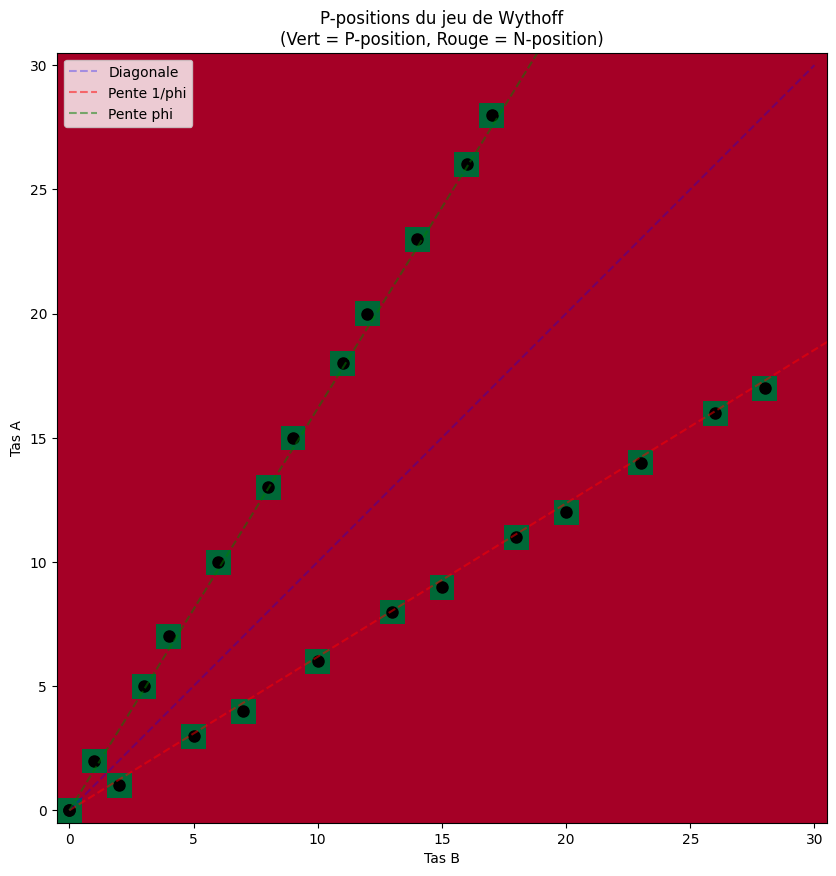

Les P-positions s'alignent sur des droites de pente phi et 1/phi !


In [6]:
# Visualisation des P-positions de Wythoff
fig, ax = plt.subplots(figsize=(10, 10))

max_val = 30

# Creer une grille de positions
grid = np.zeros((max_val + 1, max_val + 1))

# Marquer les P-positions
for a, b in wythoff_p_positions(max_val):
    if a <= max_val and b <= max_val:
        grid[a, b] = 1
        grid[b, a] = 1  # Symetrie

# Afficher
ax.imshow(grid, cmap='RdYlGn', origin='lower', extent=[-0.5, max_val+0.5, -0.5, max_val+0.5])

# Ajouter les points
for a, b in wythoff_p_positions(max_val):
    if a <= max_val and b <= max_val:
        ax.plot(b, a, 'ko', markersize=8)
        ax.plot(a, b, 'ko', markersize=8)

# Diagonale
ax.plot([0, max_val], [0, max_val], 'b--', alpha=0.3, label='Diagonale')

# Lignes de pente phi et 1/phi
x = np.linspace(0, max_val, 100)
ax.plot(x * PHI, x, 'r--', alpha=0.5, label=f'Pente 1/phi')
ax.plot(x, x * PHI, 'g--', alpha=0.5, label=f'Pente phi')

ax.set_xlim(-0.5, max_val + 0.5)
ax.set_ylim(-0.5, max_val + 0.5)
ax.set_xlabel('Tas B')
ax.set_ylabel('Tas A')
ax.set_title('P-positions du jeu de Wythoff\n(Vert = P-position, Rouge = N-position)')
ax.legend()
ax.set_aspect('equal')
plt.show()

print("Les P-positions s'alignent sur des droites de pente phi et 1/phi !")

In [7]:
def wythoff_winning_move(a: int, b: int) -> Optional[Tuple[int, int]]:
    """
    Trouve un coup gagnant au Wythoff.
    Retourne la nouvelle position (a', b') ou None si P-position.
    """
    if is_wythoff_p_position(a, b):
        return None
    
    # Essayer tous les coups possibles
    # Type 1: Retirer de A seul
    for new_a in range(a):
        if is_wythoff_p_position(new_a, b):
            return (new_a, b)
    
    # Type 2: Retirer de B seul
    for new_b in range(b):
        if is_wythoff_p_position(a, new_b):
            return (a, new_b)
    
    # Type 3: Retirer le meme nombre des deux (diagonale)
    for k in range(1, min(a, b) + 1):
        if is_wythoff_p_position(a - k, b - k):
            return (a - k, b - k)
    
    return None  # Ne devrait pas arriver pour une N-position

# Exemples de strategie
examples = [(5, 8), (7, 11), (3, 5), (10, 15)]

print("Strategie optimale au Wythoff")
print("="*50)
for a, b in examples:
    pos_type = "P" if is_wythoff_p_position(a, b) else "N"
    move = wythoff_winning_move(a, b)
    print(f"({a}, {b}) [{pos_type}]:", end=" ")
    if move:
        print(f"-> {move}")
    else:
        print("Position perdante")

Strategie optimale au Wythoff
(5, 8) [N]: -> (5, 3)
(7, 11) [N]: -> (7, 4)
(3, 5) [P]: Position perdante
(10, 15) [N]: -> (9, 15)


---

## 3. Jeux multi-composantes

Le theoreme de Sprague-Grundy nous permet d'analyser des **combinaisons de jeux** :

$$G(J_1 + J_2 + ... + J_k) = G(J_1) \oplus G(J_2) \oplus ... \oplus G(J_k)$$

Considerons un jeu composite : 3 tas de soustraction avec des regles differentes.

In [8]:
class CompositeGame:
    """Un jeu compose de plusieurs sous-jeux de soustraction."""
    
    def __init__(self, games: List[Tuple[Set[int], int]]):
        """
        games: liste de (moves, taille) pour chaque composante
        """
        self.games = games
        self.memos = [{} for _ in games]
    
    def grundy(self, component: int, size: int) -> int:
        """Grundy d'une composante."""
        moves = self.games[component][0]
        return grundy_subtraction(size, moves, self.memos[component])
    
    def total_grundy(self, sizes: List[int]) -> int:
        """Grundy total = XOR des Grundy individuels."""
        return nim_sum(*[self.grundy(i, s) for i, s in enumerate(sizes)])
    
    def position_type(self, sizes: List[int]) -> str:
        """P ou N."""
        return 'P' if self.total_grundy(sizes) == 0 else 'N'
    
    def find_winning_move(self, sizes: List[int]) -> Optional[Tuple[int, int]]:
        """Trouve un coup gagnant. Retourne (composante, nouvelle_taille)."""
        if self.total_grundy(sizes) == 0:
            return None
        
        for i, (moves, _) in enumerate(self.games):
            target_g = nim_sum(*[self.grundy(j, sizes[j]) for j in range(len(sizes)) if j != i])
            
            # Chercher une taille qui donne ce Grundy
            for new_size in range(sizes[i]):
                if self.grundy(i, new_size) == target_g:
                    return (i, new_size)
        
        return None

# Creer un jeu composite : 3 jeux de soustraction differents
composite = CompositeGame([
    ({1, 2}, 7),      # Composante 0: S({1,2}) avec 7 jetons
    ({1, 3, 4}, 5),   # Composante 1: S({1,3,4}) avec 5 jetons  
    ({2, 3}, 6),      # Composante 2: S({2,3}) avec 6 jetons
])

sizes = [7, 5, 6]
print("Jeu composite : 3 jeux de soustraction")
print("="*50)
print(f"Composante 0: S({{1,2}}) avec {sizes[0]} jetons -> G={composite.grundy(0, sizes[0])}")
print(f"Composante 1: S({{1,3,4}}) avec {sizes[1]} jetons -> G={composite.grundy(1, sizes[1])}")
print(f"Composante 2: S({{2,3}}) avec {sizes[2]} jetons -> G={composite.grundy(2, sizes[2])}")
print(f"\nGrundy total: {composite.total_grundy(sizes)}")
print(f"Position: {composite.position_type(sizes)}")

move = composite.find_winning_move(sizes)
if move:
    i, new_size = move
    print(f"\nCoup gagnant: Composante {i}, reduire de {sizes[i]} a {new_size}")
    new_sizes = sizes.copy()
    new_sizes[i] = new_size
    print(f"Nouvelle position: {new_sizes} -> G={composite.total_grundy(new_sizes)}")

Jeu composite : 3 jeux de soustraction
Composante 0: S({1,2}) avec 7 jetons -> G=1
Composante 1: S({1,3,4}) avec 5 jetons -> G=3
Composante 2: S({2,3}) avec 6 jetons -> G=0

Grundy total: 2
Position: N

Coup gagnant: Composante 1, reduire de 5 a 1
Nouvelle position: [7, 1, 6] -> G=0


---

## 4. Visualisation interactive

Creons une visualisation des valeurs de Grundy pour mieux comprendre leur structure.

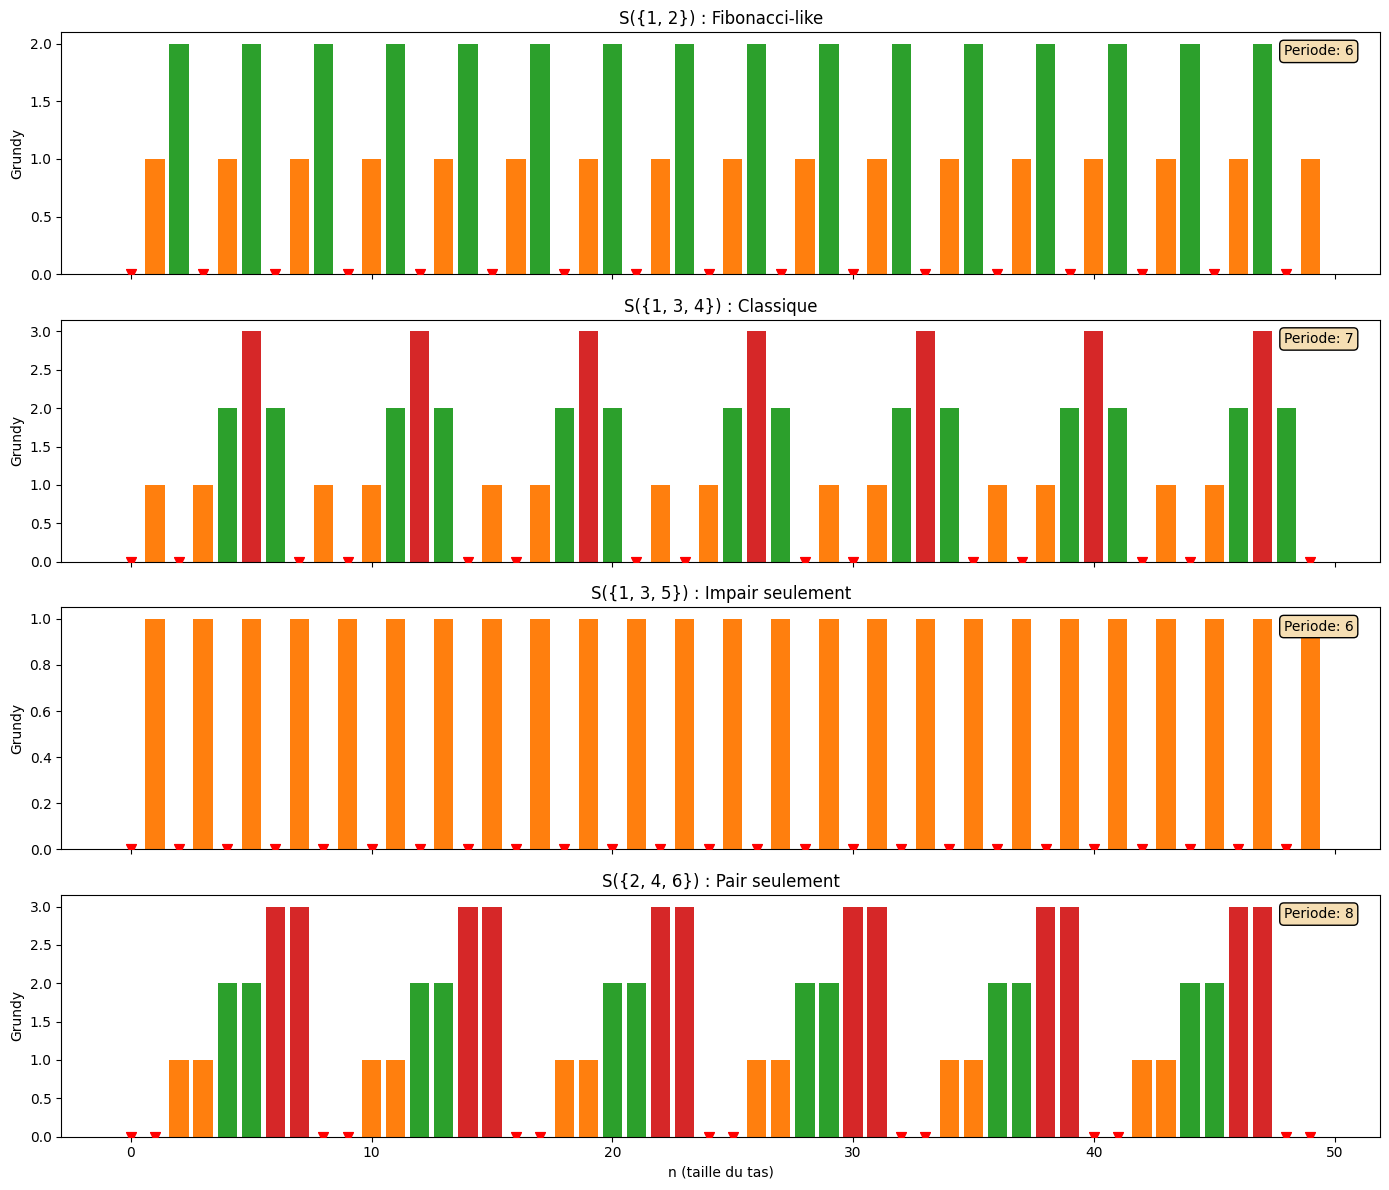

In [9]:
def visualize_grundy_comparison(games_dict: dict, max_n: int = 50):
    """
    Compare les valeurs de Grundy de plusieurs jeux.
    """
    n_games = len(games_dict)
    fig, axes = plt.subplots(n_games, 1, figsize=(14, 3 * n_games), sharex=True)
    if n_games == 1:
        axes = [axes]
    
    for ax, (name, moves) in zip(axes, games_dict.items()):
        memo = {}
        values = [grundy_subtraction(n, moves, memo) for n in range(max_n)]
        
        # Colorer par valeur de Grundy
        colors = [plt.cm.tab10(v % 10) for v in values]
        
        ax.bar(range(max_n), values, color=colors, edgecolor='none')
        ax.set_ylabel('Grundy')
        ax.set_title(f'S({moves}) : {name}')
        
        # Marquer les P-positions
        p_pos = [i for i, v in enumerate(values) if v == 0]
        ax.scatter(p_pos, [0] * len(p_pos), color='red', s=50, zorder=5, marker='v', label='P-positions')
        
        # Ajouter la periode si trouvee
        pre, period, _ = find_periodicity(moves, max_n=200)
        if period > 0:
            ax.text(0.98, 0.95, f'Periode: {period}', transform=ax.transAxes, 
                   ha='right', va='top', fontsize=10, 
                   bbox=dict(boxstyle='round', facecolor='wheat'))
    
    axes[-1].set_xlabel('n (taille du tas)')
    plt.tight_layout()
    plt.show()

# Comparer plusieurs jeux
games_to_compare = {
    "Fibonacci-like": {1, 2},
    "Classique": {1, 3, 4},
    "Impair seulement": {1, 3, 5},
    "Pair seulement": {2, 4, 6},
}

visualize_grundy_comparison(games_to_compare)

---

## 5. Jeu de Chomp

Le **jeu de Chomp** est un jeu **partizan** (contrairement a Nim qui est impartial) :

- Une tablette de chocolat rectangulaire $m \times n$
- A chaque tour, on mange un carre et tous les carres en haut et a droite
- Le carre en bas a gauche (0,0) est empoisonne - celui qui le mange perd

### Theoreme de Gale (1974)

Le premier joueur a une **strategie gagnante** pour toute tablette $m \times n$ avec $m, n \geq 2$.

**Mais** : la preuve est non-constructive ("strategy stealing argument"), et trouver la strategie optimale est NP-difficile !

In [10]:
def chomp_moves(position: Tuple[int, ...]) -> List[Tuple[int, ...]]:
    """Genere tous les coups legaux depuis une position."""
    moves = []
    for col in range(len(position)):
        for row in range(1, position[col] + 1):
            # Manger (row, col) et tout ce qui est au-dessus/a droite
            new_pos = list(position)
            for c in range(col, len(position)):
                new_pos[c] = min(new_pos[c], row - 1)
            # Supprimer les colonnes vides a droite
            while new_pos and new_pos[-1] == 0:
                new_pos.pop()
            if tuple(new_pos) != (0,) and new_pos:
                moves.append(tuple(new_pos))
    return moves

@lru_cache(maxsize=10000)
def chomp_is_losing(position: Tuple[int, ...]) -> bool:
    """Determine si une position est perdante (P-position)."""
    if position == (1,) or position == ():
        return True
    
    for move in chomp_moves(position):
        if chomp_is_losing(move):
            return False
    
    return True

# Analyser Chomp 3x3
print("Analyse du jeu de Chomp 3x3")
print("="*40)

initial = (3, 3, 3)
print(f"Position initiale: {initial}")
print(f"Type: {'P (perdante)' if chomp_is_losing(initial) else 'N (gagnante)'}")

print("\nCoups depuis la position initiale:")
for move in chomp_moves(initial)[:8]:
    status = "P" if chomp_is_losing(move) else "N"
    print(f"  {move} [{status}]")

Analyse du jeu de Chomp 3x3
Position initiale: (3, 3, 3)
Type: N (gagnante)

Coups depuis la position initiale:
  (1, 1, 1) [N]
  (2, 2, 2) [N]
  (3,) [N]
  (3, 1, 1) [P]
  (3, 2, 2) [N]
  (3, 3) [N]
  (3, 3, 1) [N]
  (3, 3, 2) [N]


/tmp/ipykernel_26061/1014831080.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((col, row), 0.9, 0.9, color=color, edgecolor='brown')


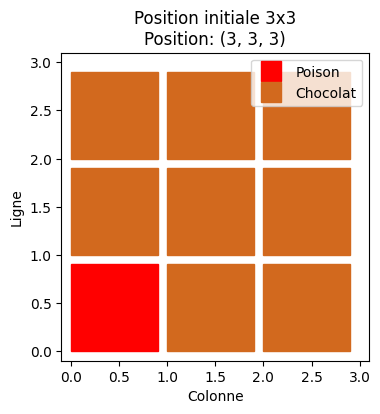

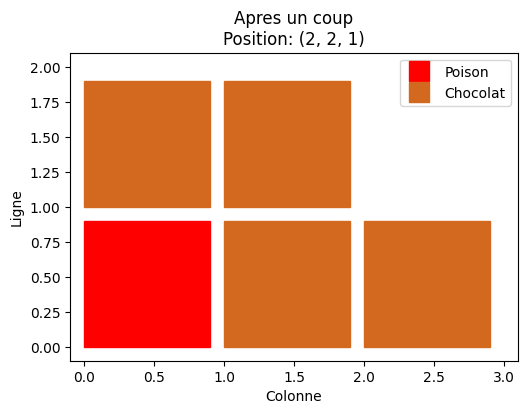

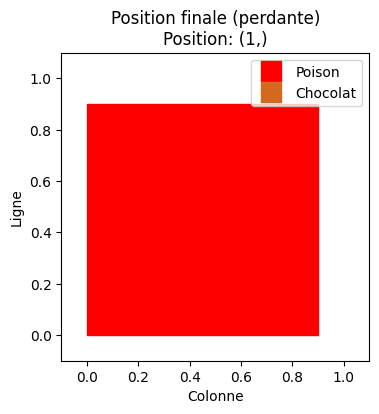

In [11]:
def visualize_chomp(position: Tuple[int, ...], title: str = "Chomp"):
    """Visualise une position de Chomp."""
    if not position:
        position = (0,)
    
    max_height = max(position) if position else 1
    n_cols = len(position)
    
    fig, ax = plt.subplots(figsize=(max(6, n_cols), max(4, max_height)))
    
    for col in range(n_cols):
        for row in range(position[col]):
            color = 'red' if (col == 0 and row == 0) else 'chocolate'
            rect = plt.Rectangle((col, row), 0.9, 0.9, color=color, edgecolor='brown')
            ax.add_patch(rect)
    
    ax.set_xlim(-0.1, n_cols + 0.1)
    ax.set_ylim(-0.1, max_height + 0.1)
    ax.set_aspect('equal')
    ax.set_title(f"{title}\nPosition: {position}")
    ax.set_xlabel('Colonne')
    ax.set_ylabel('Ligne')
    
    ax.plot([], [], 's', color='red', markersize=15, label='Poison')
    ax.plot([], [], 's', color='chocolate', markersize=15, label='Chocolat')
    ax.legend(loc='upper right')
    
    plt.show()

# Visualiser quelques positions
visualize_chomp((3, 3, 3), "Position initiale 3x3")
visualize_chomp((2, 2, 1), "Apres un coup")
visualize_chomp((1,), "Position finale (perdante)")

---

## Exercices

### Exercice 1 : Periode de S({1, 2, 4, 8})

Trouvez la periode et la pre-periode du jeu de soustraction S({1, 2, 4, 8}).

### Exercice 2 : Wythoff generalise

Dans le **Wythoff (k)**, on peut retirer jusqu'a k fois le meme nombre des deux tas. Implementez l'analyse pour k=2.

### Exercice 3 : Simulation de Chomp

Implementez un joueur optimal pour Chomp 4x4 et jouez contre lui.

In [12]:
# Exercice 1 - Solution
moves = {1, 2, 4, 8}
pre, period, seq = find_periodicity(moves, max_n=200)
print(f"S({moves}):")
print(f"  Pre-periode: {pre}")
print(f"  Periode: {period}")
print(f"  Premiers termes: {seq[:20]}")

S({8, 1, 2, 4}):
  Pre-periode: 0
  Periode: 6
  Premiers termes: [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1]


---

## Resume

| Concept | Description |
|---------|-------------|
| **Periodicite** | Les Grundy des jeux de soustraction sont ultimement periodiques |
| **Wythoff** | P-positions liees au nombre d'or phi |
| **Jeux composites** | Grundy total = XOR des Grundy individuels |
| **Chomp** | Jeu partizan NP-difficile, strategie non-constructive |

### Ressources

- Conway, J.H. *On Numbers and Games* (2001)
- Berlekamp, E., Conway, J., Guy, R. *Winning Ways* (2001)
- [Sprague-Grundy Theorem (Wikipedia)](https://en.wikipedia.org/wiki/Sprague%E2%80%93Grundy_theorem)

---

**Navigation** : [<< 8-CombinatorialGames](GameTheory-8-CombinatorialGames.ipynb) | [Index](README.md) | [8b-Lean-CombinatorialGames](GameTheory-8b-Lean-CombinatorialGames.ipynb)